In [33]:
import math
import string
import re
import pickle

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

nltk.download("wordnet")
nltk.download('stopwords')

RAND_STATE = 1

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Read in the input data**

Class labels are 

0 - Normal (neutral, non-hateful negative, and positive) 

1 - Risk of Harming Others 

2 - Risk of Harming Self

In [35]:
input_fn = 'gdrive/My Drive/COEN140/group-project/data/train.csv'
preprocessed_fn = 'gdrive/My Drive/COEN140/group-project/data/preprocessed.csv'
df = pd.read_csv(input_fn)
df

,text,class
0,A first feature of the present invention is a ...,0
1,"According to the present invention, it is poss...",0
2,"According to the invention, it is possible to ...",0
3,"To solve the problems described above, a proce...",0
4,The vehicle seat device comprises front moveme...,0
...,...,...
138792,"Due to the specific steps, the method for prod...",0
138793,According to the present disclosure as describ...,0
138794,"The terminal, method for controlling the termi...",0
138795,how can you tnk it's acceptable to call people...,0


# Pre-processing
Given a DataFrame of documents and their associated class labels, clean the text in the documents by removing punctuation and words less than 4 letters (other than "I" and "me"). Then, stem the words in each document. Finally, create a CSR matrix by vectorizing the words using Count Vectorizer and using tdif for Inverse Document Frequency.


---


Although pronouns like "I", "me" and "myself" are considered to be "stop-words", these words are important to give context to a document to distinguish between hate and depression. 



> For example: "I hate myself" becomes "hate" after filtering stop words, which would be incorrectly classified as hate, rather than as depression.

In [36]:
# split feature matrix and class labels
docs = df['text']
classes = df['class']

In [37]:
# remove certain pronouns from stop words to give more context 
sw_nltk = stopwords.words('english')
pronouns = ['i', 'me', 'myself', 'my','you','your','yours','yourself', 
            'yourselves','he','him','his','himself','she',"she's",'her',
            'hers','herself']
sw_nltk = [w for w in sw_nltk if w not in pronouns]

# lemmatizer
lem = WordNetLemmatizer()

In [38]:
def text_pre_processing(input_string):
    """ Given a document (a string) preprocess the document 
    by removing punctuation, extra whitespace, and stop words 
    and return the preprocessed document. """

    stop_words = set(sw_nltk)
    pattern = r'\b(' + r'|'.join(stop_words) + r')\b\s*'


    # remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', input_string)

    # remove stopwords
    words = re.sub(pattern, '', text.lower(), flags=re.IGNORECASE)

    # remove extra whitespace
    words = re.sub('\s+', ' ', words).strip()

    words = words.split()
    words = ' '.join([lem.lemmatize(w) for w in words])
    return words

In [39]:
pp_docs = [text_pre_processing(d) for d in docs]

The entire input data will be fit to the same matrix to make sure that the training set and testing set will be in the same Euclidean space after the input data is split. We decided to use TF-IDF so that there is less weight given to frequently occuring words across all documents.


In [40]:
# Creates a vocabulary for a inverse document frequency matrix
# from the pre-processed documents
vectorizer = TfidfVectorizer().fit(pp_docs)

In [41]:
# split the input data into training and testing sets using a 70/30 split
docs_train, docs_test, cls_train, cls_test = train_test_split(pp_docs, classes, 
        train_size=0.7, test_size=0.3 , shuffle=True, random_state=RAND_STATE)

# transform the training set and testing set into a tfidf matrix
docs_train = vectorizer.transform(docs_train)
docs_test = vectorizer.transform(docs_test)

# Model Selection 

**Model Scoring**

We're using [sklearn's balanced accuracy score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) to compare models because the dataset is inherently imbalanced. The class of normal data (label 0) is overrepresented because in reality, most text is normal. However, we want to correctly predict the underrepresented classes. The score is defined as the average recall across each class.

In [42]:
def score_models(models, docs_train, cls_train, score='balanced_accuracy'): 
  """ Given a list of models, training set documents and training set class
  labels, and a cross validation score, return a list of the best models 
  based on balanced accuracy using k-fold cross validation 
  and their associated scores """
  
  scores = []
  for m in models: 

    # take the average balanced accuracy score for the model 
    # across k-fold cross validation
    scores.append((m, np.mean(cross_val_score(m, X=docs_train, y=cls_train, 
                                              scoring=score))))
  
  # sort the scores by the model with the highest accuracy 
  scores.sort(key=lambda x: x[1], reverse=True)
  return scores 

In [43]:
# keep track of the best models in a list 
best_models = []

**Support Vector Machine (SVM)**

Classifying Using SVM with No Parameter Tuning

In [44]:
svm = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, 
                    random_state=RAND_STATE, max_iter=5, tol=None)
print(f'SVM with no parameter tuning accuracy score: %.6f ' 
      % score_models([svm], docs_train, cls_train, score='accuracy')[0][1])

print(f'SVM with no parameter tuning balanced accuracy score: %.6f ' 
      % score_models([svm], docs_train,cls_train)[0][1])

SVM with no parameter tuning accuracy score: 0.912502 
SVM with no parameter tuning balanced accuracy score: 0.594555 


In [45]:
def get_best_svm(docs_train, cls_train): 
  """ Given a training set of documents and their class labels, 
  return a list of SVM models sorted by best balanced accuracy score """

  alpha_range = [1e-1, 1e-3, 1e-5, 1e-7]
  penalty_range = ['l2', 'l1', 'elasticnet']


  # linear SVM with stochastic gradient descent 
  svm_models = [SGDClassifier(loss='hinge', penalty=p,alpha=a, 
                              random_state=RAND_STATE, max_iter=5, tol=None) 
  for a in alpha_range
  for p in penalty_range ]

  return score_models(svm_models, docs_train, cls_train)

best_svm = get_best_svm(docs_train, cls_train)[0]
best_models.append(best_svm)
print(f'best SVM model {best_svm[0]}, balanced accuracy score: %.6f' % best_svm[1])

best SVM model SGDClassifier(alpha=1e-07, max_iter=5, random_state=1, tol=None), balanced accuracy score: 0.787599


**Naive Bayes Classifier**

In [46]:
nb = MultinomialNB()
print(f'Naive Bayes with no parameter tuning accuracy score: %.6f ' 
      % score_models([nb], docs_train, cls_train, score='accuracy')[0][1])
print(f'Naive Bayes with no parameter tuning balanced accuracy score: %.6f' 
      % score_models([nb], docs_train, cls_train)[0][1])

Naive Bayes with no parameter tuning accuracy score: 0.909106 
Naive Bayes with no parameter tuning balanced accuracy score: 0.693304


In [47]:
np.seterr(divide = 'ignore')  # ignore divide by zero 
def get_best_nb(docs_train, cls_train): 
  """ Given a training set of documents and their class labels, 
  return a list of Multinomial Naive Bayes models 
  sorted by best balanced accuracy score """

  alpha_range = [2, 1, 1e-1, 1e-3, 1e-5]
  nb_models = [MultinomialNB(alpha=a) for a in alpha_range ]

  # Naive Bayes with no smoothing
  nb_models.append(MultinomialNB(alpha=0, force_alpha=True))

  return score_models(nb_models, docs_train, cls_train)

best_nb = get_best_nb(docs_train, cls_train)[0]
best_models.append(best_nb)
print(f'best Naive Bayes model {best_nb[0]}, balanced accuracy score: %.6f'
         % best_nb[1] )

best Naive Bayes model MultinomialNB(alpha=0.1), balanced accuracy score: 0.904096


**Decision Tree Classifier**

Tree-Based Classifiers are not practical because there are too many features for the algorithm to split on.

In [48]:
# dtc = DecisionTreeClassifier(random_state=0)
# print(f'Decision Tree with no parameter tuning accuracy score: %.6f ' 
#       % score_models([dtc], docs_train, cls_train, score='accuracy')[0][1])
# print(f'Decision Tree with no parameter tuning balanced accuracy score: %.6f' 
#       % score_models([dtc], docs_train, cls_train)[0][1])

In [49]:
# def get_best_dtc(docs_train, cls_train):
#   """ Given a training set of documents and their class labels, 
#   return a list of Decision Tree Classifier models 
#   sorted by best balanced accuracy score """ 
#   depth_range = (None, 1, 10, 20, 50)
#   leaf_samples_range = (1, 10, 20, 50)
#   impurity_decrease_range = range(0,5)
#   dtc_models = [  DecisionTreeClassifier(random_state=0, 
#                       max_depth=d, min_samples_leaf=l, min_impurity_decrease=i) 
#   for i in impurity_decrease_range  
#   for l in leaf_samples_range 
#   for d in depth_range ]

#   return score_models(dtc_models, docs_train, cls_train)



# best_dtc = get_best_dtc(docs_train, cls_train)[0]
# best_models.append(best_dtc)
# print(f'best Decision Tree Classifier model {best_dtc[0]}, balanced accuracy score: %.6f'
#          % best_dtc[1] )

**Logistic Regression**

In [50]:
reg = LogisticRegression(max_iter=500)
print(f'Logistic Regression with no parameter tuning accuracy score: %.6f ' 
      % score_models([reg], docs_train, cls_train, score='accuracy')[0][1])
print(f'Logistic Regression with no parameter tuning balanced accuracy score: %.6f' 
      % score_models([reg], docs_train, cls_train)[0][1])

Logistic Regression with no parameter tuning accuracy score: 0.932007 
Logistic Regression with no parameter tuning balanced accuracy score: 0.753279


In [51]:
def get_best_lreg(docs_train, cls_train): 
  """ Given a training set of documents and their class labels, 
  return a list of Logistic Regression models 
  sorted by best balanced accuracy score """
  
  solvers = ['newton-cg', 'sag', 'saga']

  reg_models = [LogisticRegression(solver=s, max_iter=500) 
  for s in solvers]
  return score_models(reg_models, docs_train, cls_train)

best_reg = get_best_lreg(docs_train, cls_train)[0]
best_models.append(best_reg)
print(f'best Logistic Regression model {best_reg[0]}, balanced accuracy score: %.6f'
         % best_reg[1] )

best Logistic Regression model LogisticRegression(max_iter=500, solver='newton-cg'), balanced accuracy score: 0.753331


# Model Evaluation

Sort the best models in descending order by balanced accuracy scores

In [52]:
best_models.sort(key=lambda x: x[1], reverse=True)
best_models

[(MultinomialNB(alpha=0.1), 0.9040963315917108),
 (SGDClassifier(alpha=1e-07, max_iter=5, random_state=1, tol=None),
  0.7875993963325043),
 (LogisticRegression(max_iter=500, solver='newton-cg'), 0.753330995951432)]

**Classifying the Documents in the Test Set Using the Best Model** (according to balanced accuracy score)

In [64]:
def classify_test_docs(model):
  """ Given a classifer model, return the predicted
  class labels for the test set """

  model.fit(docs_train, cls_train)
  return model.predict(docs_test)

In [65]:
# classify the validation set using the best model and 
# display the classification report, which shows metrics for each class 
print(classification_report(cls_test, classify_test_docs(best_models[0][0])))

              precision    recall  f1-score   support

           0       0.99      0.87      0.93     35580
           1       0.40      0.87      0.55      3004
           2       0.76      0.98      0.86      3056

    accuracy                           0.88     41640
   macro avg       0.72      0.91      0.78     41640
weighted avg       0.93      0.88      0.89     41640



**Visualizing Precision, Recall, and F-beta Score**

In [54]:
model_names = [m[0] for m in best_models]
reports = []
for m in model_names:
   m.fit(docs_train, cls_train)
   y_pred = m.predict(docs_test)
   reports.append(precision_recall_fscore_support(cls_test, y_pred))

In [55]:
def compare_models(reports, score): 
  score_idx = 0
  match score: 
    case 'precision': 
      score_idx = 0
    case 'recall': 
      score_idx = 1
    case 'f1-beta': 
      score_idx = 2
    case 'support': 
      score_idx = 3
    case _: 
      score_idx = 0
  
  class_names = ['normal', 'risk to others', 'risk to self']
  models_precision = [rep[score_idx] for rep in reports]
  class_models_precision = dict(zip(model_names,
                                    np.asarray([rep[score_idx] 
                                                for rep in reports])))


  x = np.arange(len(class_names))  # the label locations
  width = 0.30  # the width of the bars
  multiplier = 0

  fig, ax = plt.subplots(layout='constrained')

  for attribute, measurement in class_models_precision.items():
      offset = width * multiplier
      rects = ax.bar(x + offset, measurement, width, label=attribute)
      ax.bar_label(rects, padding=3)
      multiplier += 1

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel(score)
  ax.set_title(f'{score} of models by class')
  ax.set_xticks(x + width, class_names)
  ax.legend(loc='upper left', ncols=3)
  ax.set_ylim(0, 1.2)

  plt.show()

Precision is the ability of the classifier not to label as positive a sample that is negative.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


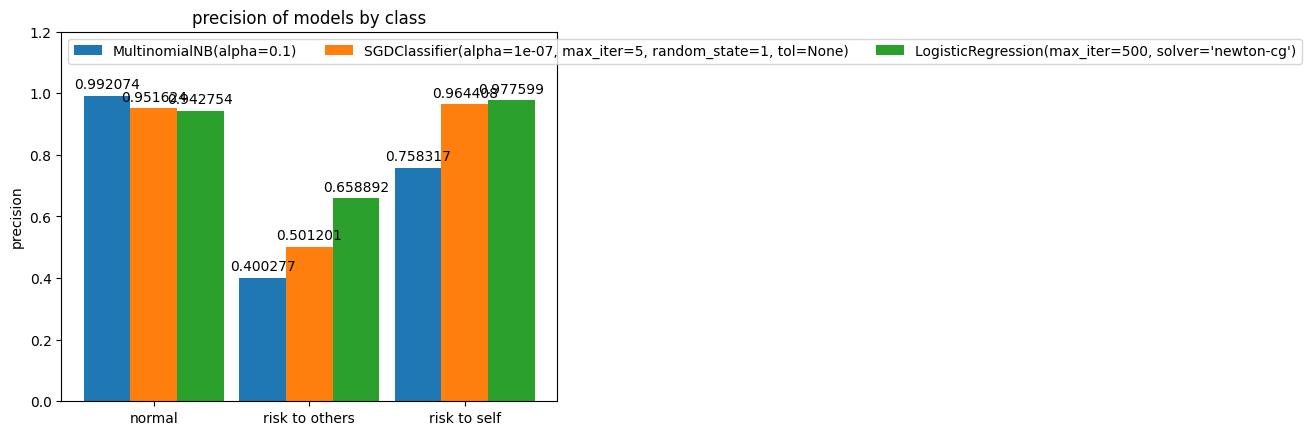

In [56]:
compare_models(reports, 'precision')

Recall is the ability of the classifier to find all the positive samples.

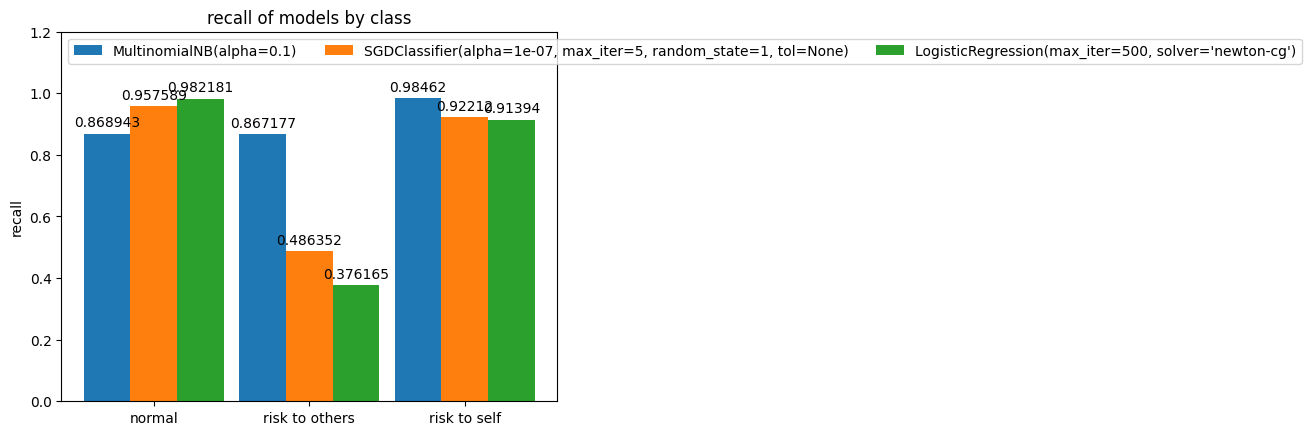

In [57]:
compare_models(reports, 'recall')

F-beta score is the weighted harmonic mean of precision and recall, reaching its optimal value at 1 and its worst value at 0.

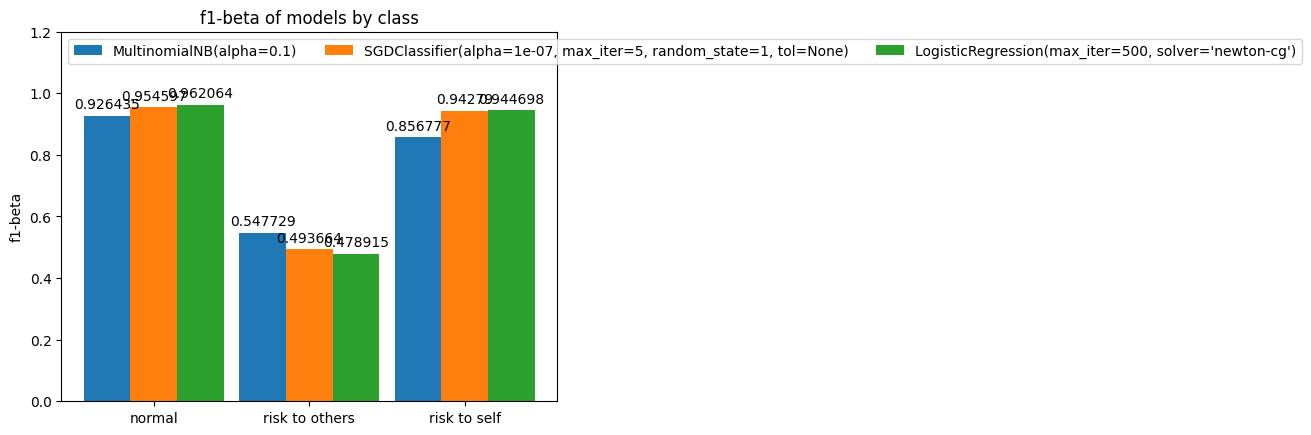

In [58]:
compare_models(reports, 'f1-beta')

# Results
Multinomial Naive Bayes sufferss slightly from precision on the minority classes compared to the other models but it has a higher recall. Because the output from the model is read by an analyst before a notification is sent to either a facutly member or parental guardian, we want to be able to catch most instances of harmful text. If the model is imprecise, the output can be looked at by a human and get corrected.

**Classifying Any Document with Unknown Labels**

In [59]:
# fit the model to the entire training set
model = best_models[0][0].fit(vectorizer.transform(pp_docs), classes)

In [69]:
def classify_unknown_text(model, test):
  """ Given  and a set of documents
  with unknown labels, predict the class labels 
  for each test document. """
  test = [text_pre_processing(d) for d in test] # pre-process the test input 
  test = vectorizer.transform(test)             # create a tfidf matrix 
  cls_pred = model.predict(test)                # predict class

  return cls_pred

Write the model to disk so that it doesn't need to be retrained for future use. We decided to use joblib instead of Python's pickling library because it is better at saving large NumPy arrays. 

In [62]:
from joblib import dump, load
model_fn = 'gdrive/My Drive/COEN140/group-project/data/model.joblib'
dump(model, model_fn)

['gdrive/My Drive/COEN140/group-project/data/model.joblib']